In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML, display, Image, HTML
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

datadir = '../../datasets/Hands_on_5_Spapros'

# Advanced probeset selection

In this tutorial we look into customizing the gene set selection for more specific use cases and explore the parameters 
of the selection procedure. 

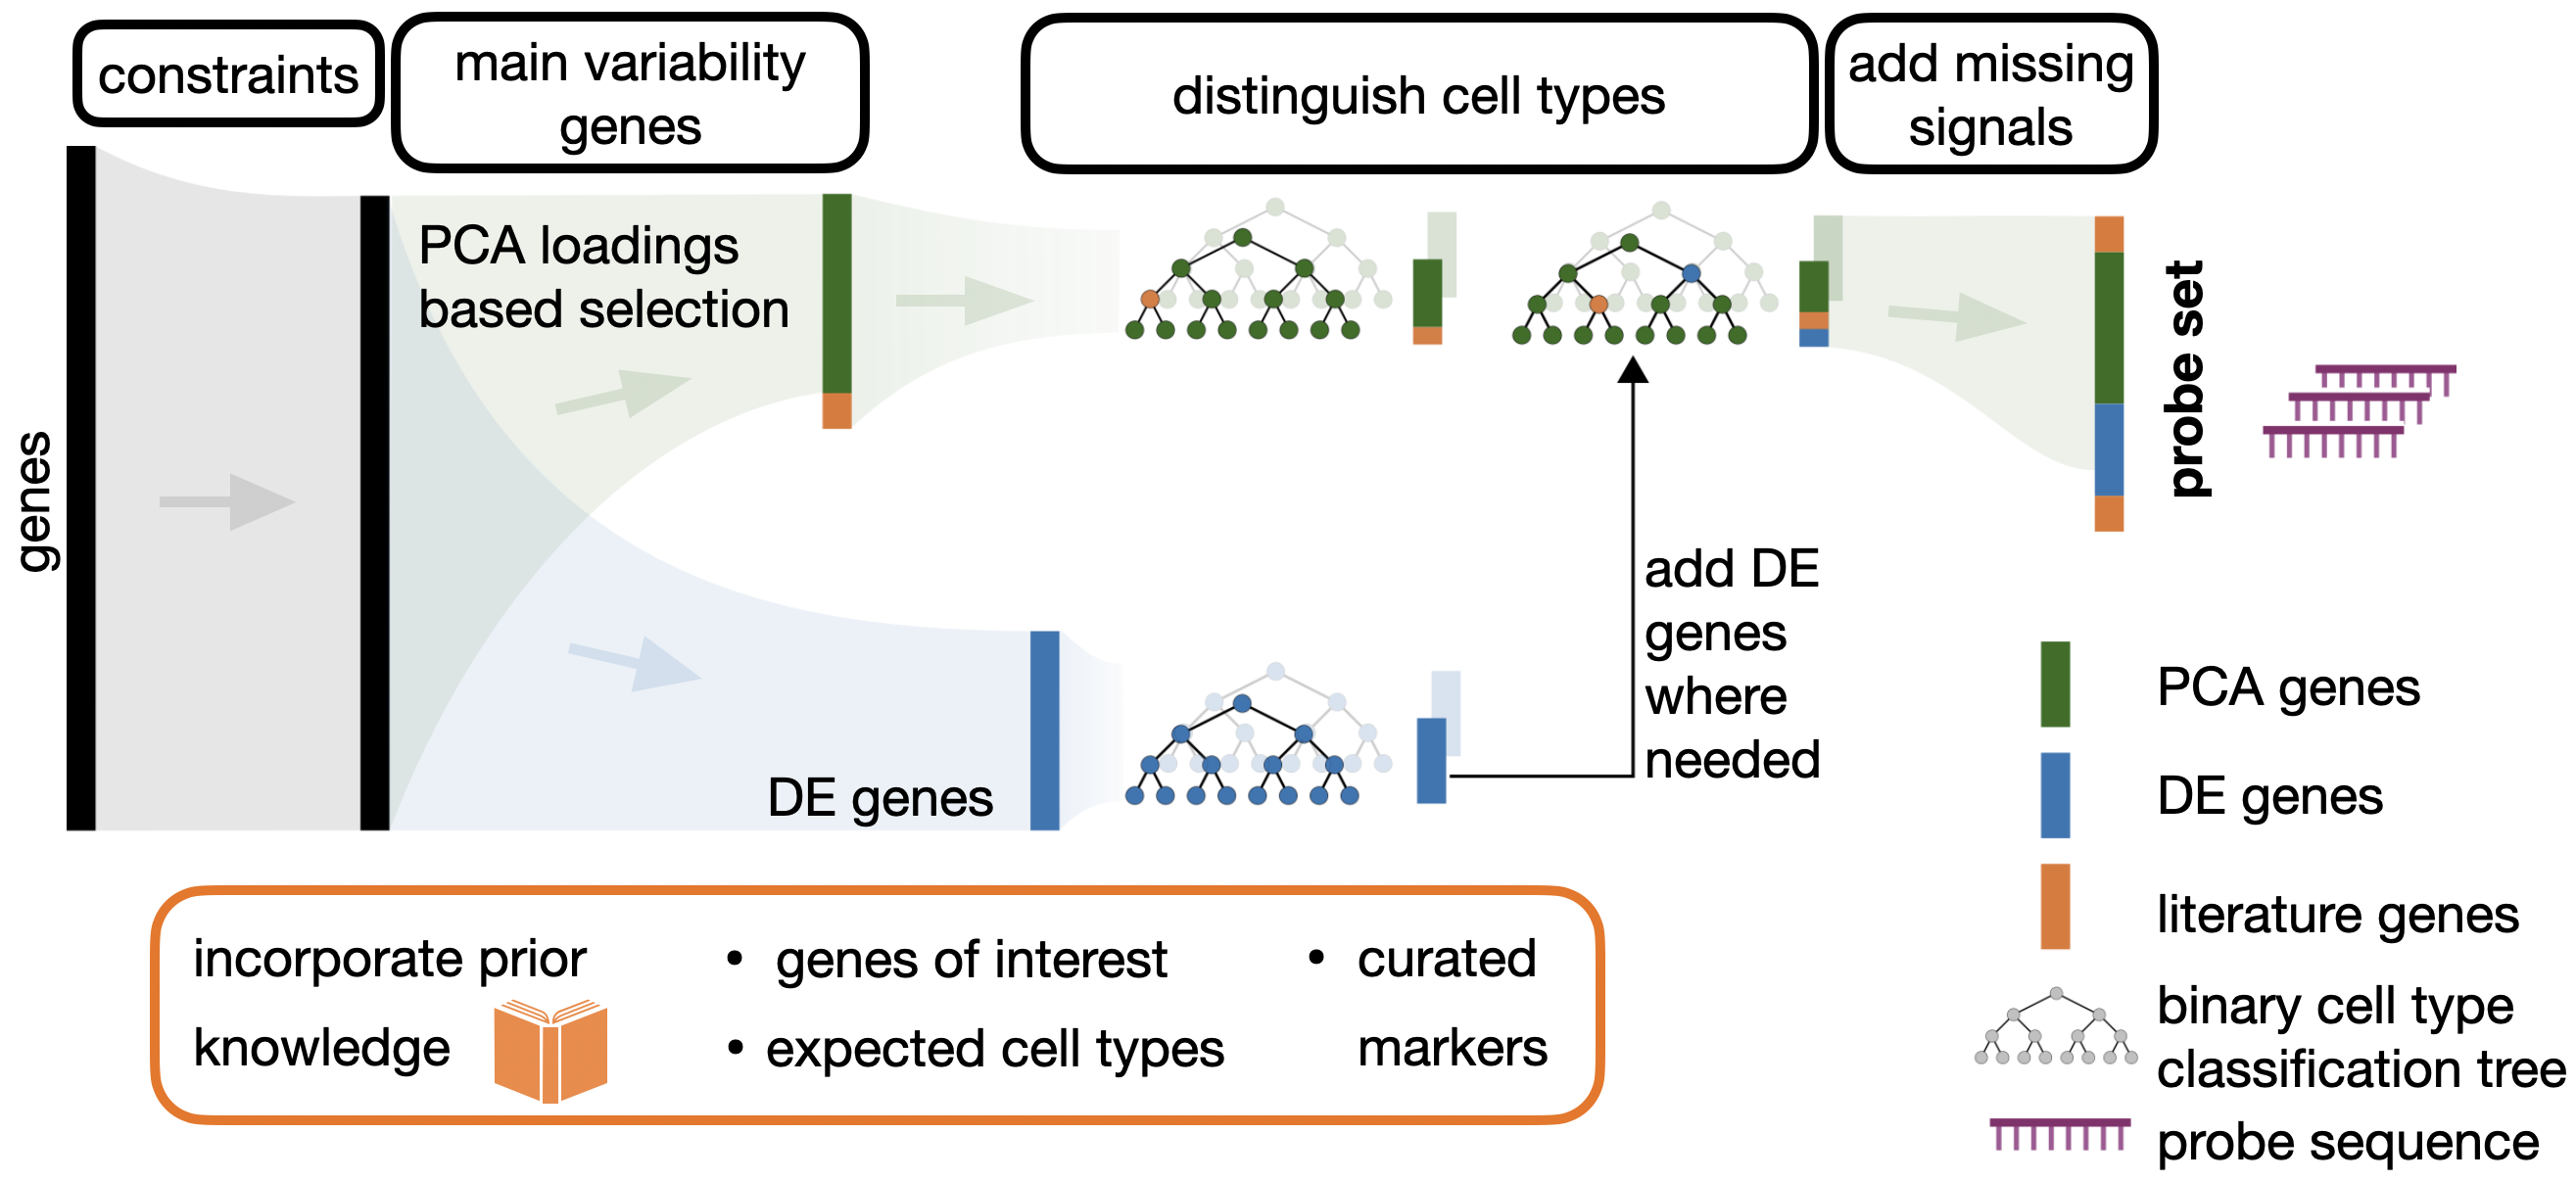

In [3]:
Image("./abstract_figures/selection_procedure.png", width=700, embed=True)


The Spapros probeset selection pipeline simultaneously optimizes for capturing transcriptional variation and cell type identification while taking into account prior knowledge, technical constraints and probe design. The main steps, as visualized in the figure above, are: 

**Constrains**

In the first step, genes are filtered based on technology specific probe design constraints. This part is captured in the [end-to-end probeset selection tutorial](./spapros_tutorial_end_to_end_selection.ipynb). (Besides probe design constraints also expression level constraints can be applied as shown in the [Selection with experession constraints](#v.-Selection-with-expression-constraints) example below. Those affect multiple steps of the pipeline though)

**Variable genes**

The next step is a PCA based selection of genes that capture general variation. The subsequent steps of the pipeline are encouraged to select from that set of genes. If you want the selection to be focused only on marker genes and cell type classification, the PCA-based selection step can be omitted, see the [Cell type classification only](#ii.-Cell-type-classification-only) example for this case.

**Distinguish celltypes**

For each cell type, a binary classification tree is trained on the previously selected gene set. Here the pipeline builds for each cell type a combinatorial rule how to distinguish it from other cell types.

**DE gene addition**

Similarly to the last step, trees are also trained on DE genes and compared to the trees trained on the PCA based selection. If a DE tree performs better with respect to cell type classification, then DE genes are added to the already selected gene set.

**Prior knowledge**

There are two possibilities to incorporate prior knowledge. For both, we present use cases in this tutorial: 

- [Select a few additional genes](#i.-Select-a-few-additional-genes): pre-selected genes are augmented by combinatorially selecting additional genes around them
- [Selection with curated marker list](#iv.-Selection-with-curated-marker-list): add markers from a given list in case the signals from that list are not captured with the already selected genes

**Probe design**

Design the final technology specific probes for the selected genes. As the **Constraints** step, this part is also only captured in the [end-to-end probeset selection tutorial](./spapros_tutorial_end_to_end_selection.ipynb).


For a detailed description of the pipeline check out our [preprint](TODO: Add link when bioarxiv is out) (especially the results section *end-to-end probe set selection with Spapros* and the *methods* section).


**Content**  

0. [Import packages](#0.-Import-packages)  
1. [Load and preprocess data](#1.-Load-and-preprocess-data)  
2. [Use cases](#2.-Use-cases)  
    i. [Select a few additional genes](#i.-Select-a-few-additional-genes)  
    ii. [Cell type classification only](#ii.-Cell-type-classification-only)  
    iii. [Selection for high numbers of genes (> 150)](#iii.-Selection-for-high-numbers-of-genes-(-150))  
    iv. [Selection with curated marker list](#iv.-Selection-with-curated-marker-list)  
    v. [Selection with expression constraints](#v.-Selection-with-expression-constraints)  
    vi. [Your use case is not captured?](#vi.-Your-use-case-is-not-captured)
3. [What's next](#3.-What's-next)  

## 0. Import packages

In [4]:
import numpy as np
import scanpy as sc
import spapros as sp

In [5]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={sp.__version__}")

spapros==0.1.5


## 1. Load and preprocess data

For Spapros selections the count data should be log-normalised. Notably genes should **not** be scaled to mean=0 and std=1. We pre-select a given number of highly variable genes, here 1000. In real world applications we typically go for 8000.   
    
The example data set that we use here has a raw version and a processed version with scaled counts. To get log normalised counts we use the raw version. Cell and gene filters, cell type annotations, and the umap embedding we get from the processed version.

In [6]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()

# Get infos from the processed dataset
adata = adata[adata_tmp.obs_names, adata_tmp.var_names]
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata.obsm['X_umap'] = adata_tmp.obsm['X_umap']
del adata_tmp

# Preprocess counts and get highly variable genes
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="cell_ranger", n_top_genes=1000)

adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

## 2. Use cases

We will go through some specific use cases for gene selection.

### i. Select a few additional genes

In some situations you already selected multiple genes that you want to measure in a targeted spatial transcriptomics experiment but you still have capacity for further genes. For this scenario the `preselected_genes` parameter was introduced. 

Let's distinguish two scenarios    

1. We preselected 40 genes and want to add 10 (adds up to 50 in total)    
2. We preselected 40 genes and want to add 100 (adds up to 140 in total)    

For the 2. scenario simply adding the first 40 genes in `preselected_genes` and going with default parameters is the right way to go. For the 1. scenario (which we look at in the code below) the parameter `n_pca_genes` should be reduced. The reason is that Spapros will build trees based on the pre selected genes and the genes from the PCA selection. If there are a lot of PCA genes in the pool, then the trees might ignore most of the preselected genes. This is not extremly problematic, but it's preferable to build up our combinatorial rules on the pre selected genes. We'll reduce `n_pca_genes` from 100 (default) to 20 for the given case. Note however that the `preselected_genes` can include genes that overlap with the pca genes, therefore we more specifically set `n_pca_genes` to the number that provides us 20 more pca genes on top of the preselected list.

In [7]:
# list of pre selected genes
preselected_genes = [
    'PF4', 'HLA-DPB1', 'FCGR3A', 'GZMB', 'CCL5', 'S100A8', 'IL32', 'HLA-DQA1', 'NKG7', 'AIF1', 'CD79A', 'LTB', 'TYROBP',
    'HLA-DMA', 'GZMK', 'HLA-DRB1', 'FCN1', 'S100A11', 'GNLY', 'GZMH', 'CST3', 'RBM39', 'HLA-DPA1', 'LST1', 'LGALS2', 
    'FCER1A', 'MS4A1', 'TRAF3IP3', 'PRF1', 'LGALS1', 'PRDX1', 'ATP5O', 'C1orf162', 'CTSS', 'SELL', 'CTSW', 'GIMAP4', 
    'LINC00926', 'MS4A6A', 'GSTP1'
]

# Get `n_pca_genes` to obtain the top 20 pca genes that are not already in preselected_genes
tmp = sp.se.select_pca_genes(adata, n=adata.n_vars, inplace=False)["selection_ranking"]
n_pca_genes = tmp.loc[~tmp.index.isin(preselected_genes)].sort_values().iloc[:20].max().astype(int)

# create an instance of the ProbesetSelector class
selector = sp.se.ProbesetSelector(
    adata, 
    n=50, 
    n_pca_genes=n_pca_genes,
    preselected_genes=preselected_genes,
    celltype_key="celltype", 
    verbosity=1, 
    save_dir="spapros_selection_advanced", 
)

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_advanced


The tree training step requires ~30GB memory and 16 CPUs, which might not be available so you can instead load the precomputed results. 
We ran:
```python
selector.select_probeset()
```

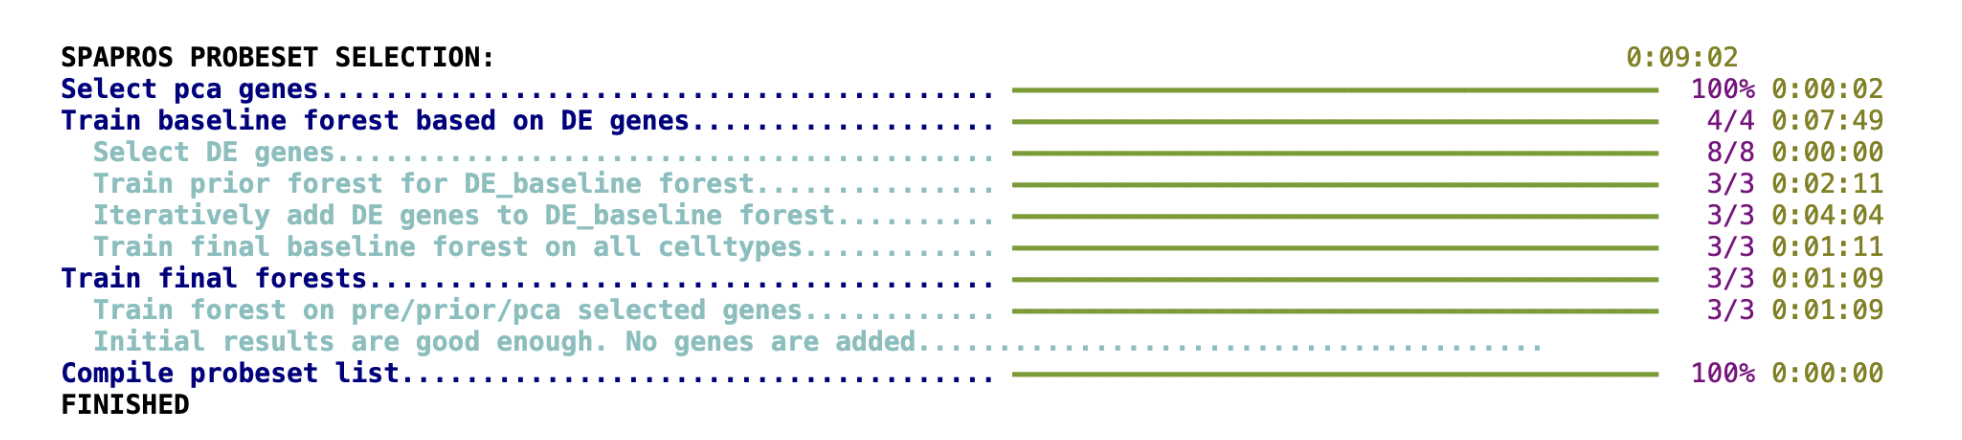

In [8]:
# copy precomputed results to writable working dir
! cp -r $datadir/spapros_selection_advanced* . 

The same methods loads the results if available: 

In [9]:
selector.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:00
PCA genes already selected..................................................................  
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Train final forests....................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:00
  Forest on pre/prior/pca selected genes already trained....................................  
  Initial results are good enough. No genes are added.......................................  
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

Now we can investigate the selected gene set. The annotations in the table describe where genes originate from:
- the first 40 genes are annotated with `pre_selected=True` 
- the added genes from 41 till 50 are annotated with `selection=True` and `pre_selected=False`

In [10]:
display(selector.probeset.head(4))
display(selector.probeset.iloc[38:42])
display(selector.probeset.iloc[48:52])

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PF4,1,True,1.0,1.0,1.0,1.000000,0.810406,True,False,False,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
CCL5,2,True,1.0,1.0,1.0,0.547887,2.553329,True,False,True,CD8 T cells,,CD8 T cells,CD8 T cells,False,True,False
GZMB,3,True,1.0,1.0,1.0,0.530616,1.252894,True,False,False,NK cells,,NK cells,NK cells,False,True,False
AIF1,4,True,1.0,1.0,1.0,0.496721,1.527255,True,False,True,FCGR3A+ Monocytes,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False


,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
GIMAP4,39,True,1.0,NaN,3.0,0.001383,2.422594,True,False,True,,,,,False,False,False
LGALS1,40,True,1.0,NaN,4.0,0.000277,2.895103,True,False,True,,,,,False,False,False
FCER1G,41,True,2.0,NaN,1.0,0.018455,1.324962,False,False,True,FCGR3A+ Monocytes,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,False,False
CD79B,42,True,2.0,NaN,1.0,0.015935,1.304571,False,False,True,B cells,,B cells,B cells,False,False,False


,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
UBE2D2,49,True,4.0,NaN,3.0,0.003920,1.757138,False,False,True,,,,,False,False,False
STK17A,50,True,5.0,NaN,5.0,0.008556,1.412642,False,False,True,,,,,False,False,False
GIMAP7,51,False,5.0,NaN,5.0,0.001398,2.961324,False,False,True,CD4 T cells,,CD4 T cells,CD4 T cells,False,False,False
ARL6IP5,52,False,6.0,NaN,6.0,0.016238,2.319184,False,False,True,,,,,False,False,False


Note that besides the `preselected_genes` parameter there is also the `prior_genes` parameter (for "prioritized genes"). This one acts similar to `preselected_genes`, however genes in `prior_genes` are not necessarily selected, they're only added to the pool of PCA preselected genes from which we build trees.

### ii. Cell type classification only

Spapros optimizes for two objectives:
1. cell type identification
2. recovery of transcriptomic variation

The procedure prioritzes the 1st objective over the 2nd. The variation recovery also leads to the selection of genes that show gradients in multiple cell types (see the example of FOS in our [publication](https://doi.org/10.1038/s41592-024-02496-z), Fig. 3). In classical gene panel selection approaches the focus lies on marker genes, ideally markers that are specific to single cell types. In the downstream analysis of spatial data genes like FOS are not useful for identifying the major cell types, these genes should even be excluded from the clustering to get better separated cell type clusters. If you don't want to select genes like FOS and only focus on the first objective you can skip the PCA-based selection by setting `n_pca_genes=0`. In that case only trees on DE genes are trained, the PCA related steps are neglected.

In [11]:
# create an instance of the ProbesetSelector class
selector = sp.se.ProbesetSelector(
    adata,
    n=30,
    n_pca_genes=0,
    celltype_key="celltype",
    verbosity=1,
    save_dir="spapros_selection_advanced_cto",
)

Note: No PCA selection will be performed since n_pca_genes = 0. The selected genes will only be based on the DE forests. In that case it can happen that fewer than n = 30 genes are selected. To get n = 30 exclude the selected genes of the first run from adata, rerun the method, and combine the results of the two runs.

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_advanced_cto


Again, we precomputed this for you: 
```python 
selector.select_probeset()
```
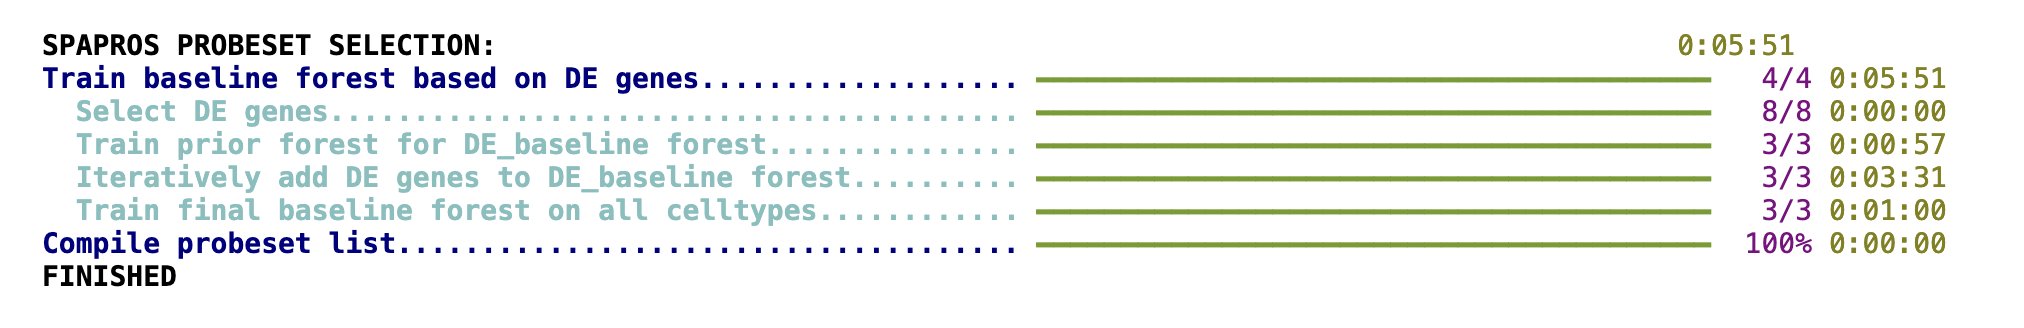

Now load the precomputed results: 

In [12]:
selector.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:00
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

In [13]:
display(selector.probeset[selector.probeset["selection"]].head(3))
display(selector.probeset[selector.probeset["selection"]].tail(3))

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PF4,1,True,1.0,1.0,1.0,1.000000,0.0,False,False,False,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
CD79A,2,True,1.0,1.0,1.0,0.906940,0.0,False,False,False,B cells,,B cells,B cells,False,True,False
S100A8,3,True,1.0,1.0,1.0,0.831315,0.0,False,False,False,CD14+ Monocytes,,CD14+ Monocytes,CD14+ Monocytes,False,True,False


,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
HLA-DQB1,28,True,1.0,NaN,1.0,0.012218,0.0,False,False,False,,Dendritic cells,Dendritic cells,Dendritic cells,False,False,False
FGFBP2,29,True,1.0,NaN,1.0,0.009360,0.0,False,False,False,,NK cells,NK cells,NK cells,False,False,False
CTSW,30,True,1.0,NaN,1.0,0.008201,0.0,False,False,False,,CD8 T cells,CD8 T cells,CD8 T cells,False,False,False


### iii. Selection for high numbers of genes (> 150)

Spapros works well over different ranges of numbers of genes to select. However, for higher numbers of genes (~ > 150, can be lower/higher for lower/higher nr of cell types) a dual selection can make sense. This is e.g. relevant for protocols like MERFISH, and also if you want to increase the robustness on the cell type classification objective (less focus on recovery of variation that is independent of cell type labels).

The idea is to run a selection first (we do not fix `n` and we do not use PCA selected genes for that run), exclude the genes of that selection, run a second (standard) selection, and combine the results of both runs.

In [14]:
# First run

# create an instance of the ProbesetSelector class
selector = sp.se.ProbesetSelector(
    adata,
    n=None,
    n_pca_genes=0,
    celltype_key="celltype",
    verbosity=1,
    save_dir="spapros_selection_advanced_many_1",
)

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_advanced_many_1


Again, we precomputed this for you: 
```python
selector.select_probeset()
```
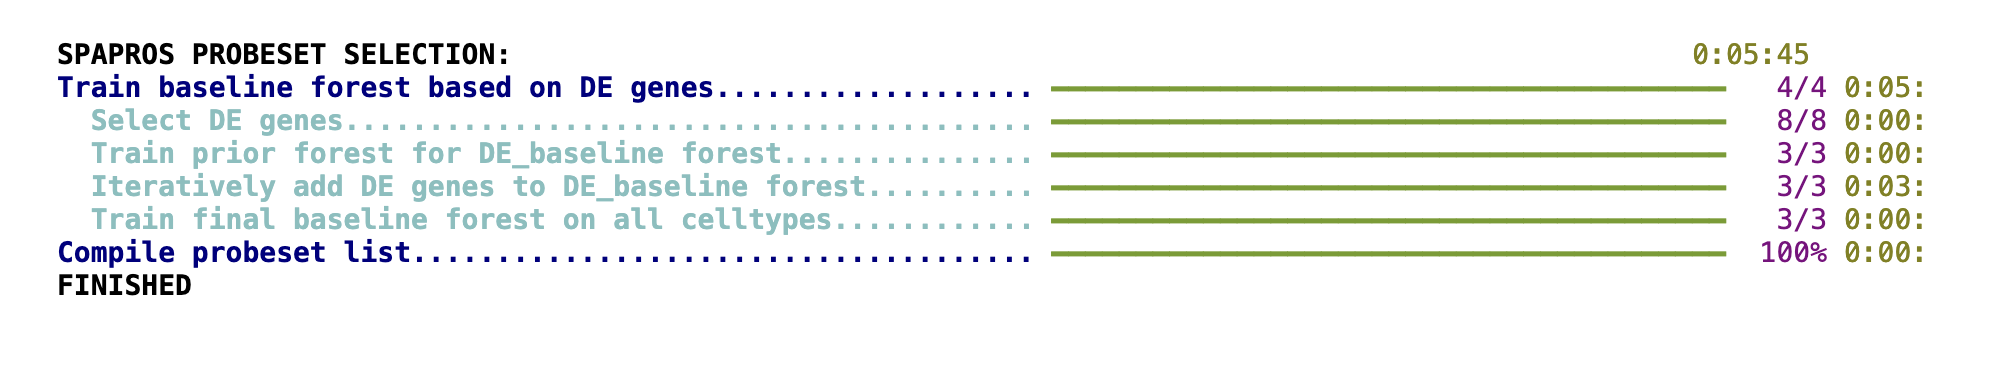

Now load the precomputed results: 

In [15]:
selector.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:00
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

In [16]:
# Save genes of the first selection
first_selection = selector.probeset[selector.probeset["selection"]].index.tolist()
n_genes_first_selection = len(first_selection)
print(n_genes_first_selection)


34


As the number of cell types is quite low in our example dataset the first selection only lead to 33 genes. Next we select the rest of genes to get to 150.

In [17]:
# Second run

# create an instance of the ProbesetSelector class
selector2 = sp.se.ProbesetSelector(
    adata[:,[v for v in adata.var_names if v not in first_selection]],
    n=150 - n_genes_first_selection,
    n_pca_genes=100,
    celltype_key="celltype",
    verbosity=1,
    save_dir="spapros_selection_advanced_many_2",
)

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_advanced_many_2


Again, we precomputed this for you: 
```python
selector2.select_probeset()
```
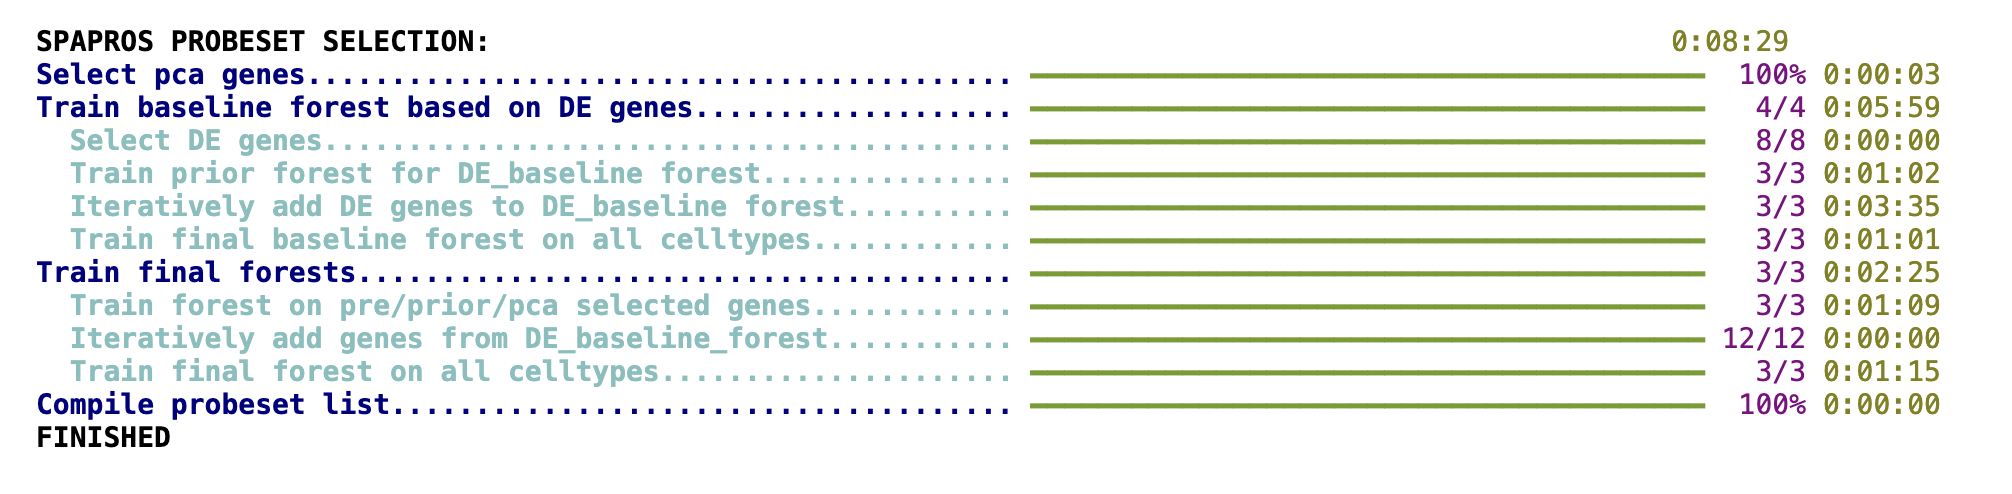

Now load the precomputed results: 

In [18]:
selector2.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:00
PCA genes already selected..................................................................  
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Train final forests....................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:00
  Forest on pre/prior/pca selected genes already trained....................................  
  Genes from DE_baseline_forest were already added..........................................  
  Final forest was alread trained...........................................................  
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

In [19]:
second_selection = selector2.probeset[selector2.probeset["selection"]].index.tolist()
final_selection = first_selection + second_selection
print(len(np.unique(final_selection)))

150


This adds up to a final gene set of 150 genes.  

For even higher numbers of genes you might want to consider running multiple additional pre selections with `n_pca_genes=0`.   

Side note: unfortunately our plotting functions are only accessible with each individual selector and not the combination of multiple selectors. 

### iv. Selection with curated marker list

Often you already have some curated list of markers. Such a list can be added as prior knowledge to achieve the following aims   

- make sure that the signal of the markers in the list are captured by the selected probe set otherwise add markers from the list   
- add markers for cell types that don't occur in `adata.obs[celltype_key]`   

The criteria how markers are added or how the "signal is captured" is described in the following. Note however that if you just want to add certain genes you can also add them with the `preselected_genes` (see [i.](#i.-Select-a-few-additional-genes)) parameter.

Let's group the cell types in the `marker_list` into:   

- *ct_group1*: cell types that also occur in `adata.obs[celltype_key]`   
- *ct_group2*: cell types that **do not** occur in `adata.obs[celltype_key]`   
   
The key parameters of the `ProbesetSelector` that define how marker signals are checked for and if markers should be added are:   

- `n_list_markers`   
- `marker_corr_th`   

You can set `n_list_markers` to an `int`, then the method will take care to have captured at least `n_list_markers` per cell type. Note however that the *ct_group1* cell types will also already be captured by the genes of the trained trees. Therefore it can make sense to have different numbers for the two groups, which is achieved by setting e.g. `n_list_markers = {'adata_celltypes':2, 'list_celltypes':3}`. As mentioned above the markers for *ct_group1* and *ct_group2* are handeled differently. For *ct_group1* the method checks if it already selected `n_list_markers` that have correlations above `marker_corr_th` (default: 0.5) with at least `n_list_markers` for a given cell type, otherwise markers from the list are added. For *ct_group2* the correlation criteria doesn't make much sense since the correlation is calculated on the given cell types in `adata` and those shouldn't express a marker for a cell type of *ct_group2*. Therefore from *ct_group2* `n_list_markers` markers are just added.

Note that there is also the `n_min_markers` parameter. This one makes sure that enough genes either from DE tests during the selection or (if given) from the `marker_list` are selected per cell type of *ct_group1*. So `n_min_markers` also applies if no `marker_list` is given.

Let's define an example marker list. We added `'cell type A'` as a *ct_group2* (i.e. not in `adata.obs[celltype_key]`) cell type example.

In [20]:
marker_list = {
    'CD4 T cells': ['IL7R'], 
    'CD14+ Monocytes': ['CD14', 'LYZ'], 
    'B cells': ['MS4A1'], 
    'CD8 T cells': ['CD8A'], 
    'NK cells': ['GNLY', 'NKG7'], 
    'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'], 
    'Dendritic cells': ['FCER1A', 'CST3'], 
    'Megakaryocytes': ['NAPA-AS1', 'PPBP'],
    'cell type A': ["Gene X", "Gene Y", "CAMK2N1"],
}

In [21]:
# create an instance of the ProbesetSelector class
selector = sp.se.ProbesetSelector(
    adata,
    n=None,
    celltype_key="celltype",
    verbosity=1,
    save_dir="spapros_selection_advanced_marker",
    marker_list=marker_list,
    n_list_markers={'adata_celltypes': 2, 'list_celltypes': 3},
)

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_advanced_marker


Again, we precomputed this for you: 
```python
selector.select_probeset()
```
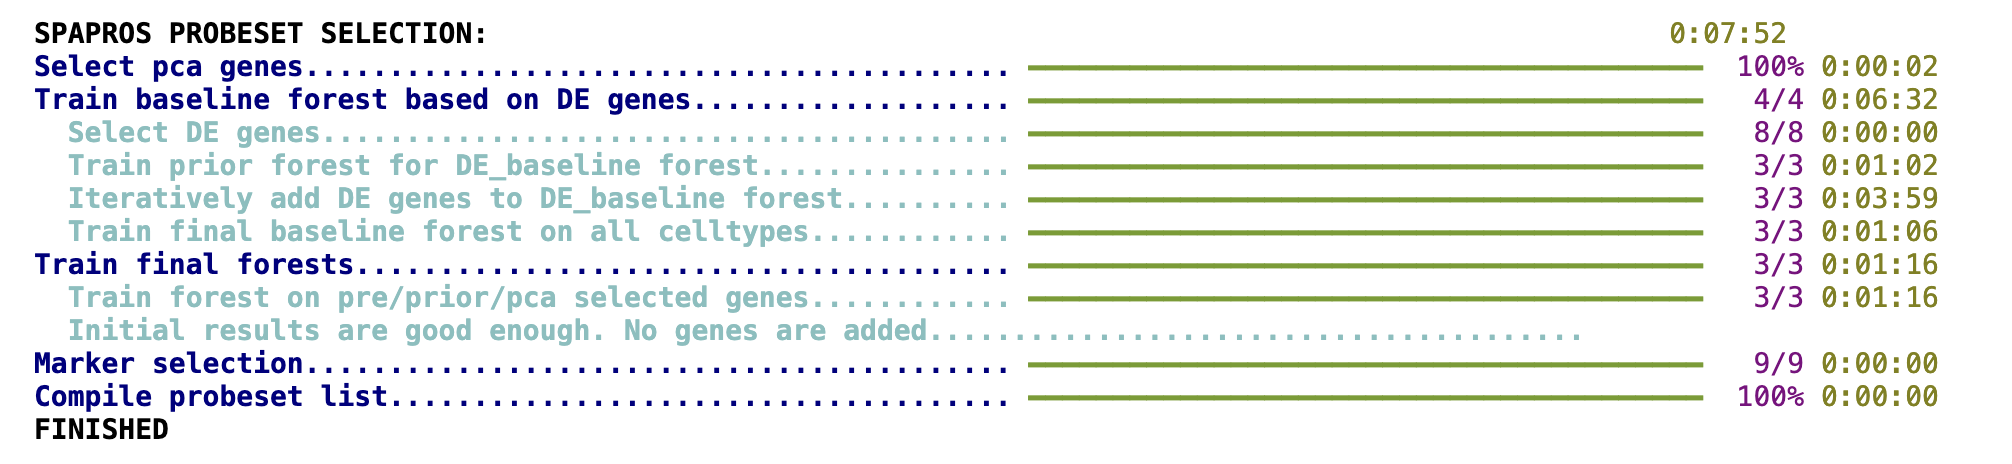

Now load the precomputed results: 

In [22]:
selector.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:01
PCA genes already selected..................................................................  
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Train final forests....................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:00
  Forest on pre/prior/pca selected genes already trained....................................  
  Initial results are good enough. No genes are added.......................................  
Marker selection.......................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   9/9 0:00:00
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:00
FINISHED

In [23]:
selector.probeset[selector.probeset["selection"]]

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
FCGR3A,1,True,1.0,1.0,1.0,0.604625,1.321374,False,False,True,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,"FCGR3A+ Monocytes,FCGR3A+ Monocytes",False,True,False
NKG7,2,True,1.0,1.0,1.0,0.248463,1.658469,False,False,True,"NK cells,CD8 T cells",,"NK cells,CD8 T cells","NK cells,CD8 T cells,NK cells",False,True,False
CST3,3,True,1.0,1.0,1.0,0.059620,1.557665,False,False,True,"CD14+ Monocytes,Dendritic cells",,"CD14+ Monocytes,Dendritic cells","CD14+ Monocytes,Dendritic cells,Dendritic cells",False,True,False
MS4A1,4,True,1.0,1.0,1.0,0.015325,0.814809,False,False,True,,,,B cells,False,True,False
CD79A,5,True,1.0,2.0,1.0,0.916721,1.226531,False,False,True,B cells,,B cells,B cells,False,True,False
CCL5,6,True,1.0,2.0,1.0,0.478418,2.553319,False,False,True,CD8 T cells,,CD8 T cells,CD8 T cells,False,True,False
IL32,7,True,1.0,2.0,1.0,0.185111,3.377421,False,False,True,CD4 T cells,,CD4 T cells,CD4 T cells,False,True,False
GNLY,8,True,1.0,2.0,1.0,0.073403,2.167562,False,False,True,NK cells,,NK cells,"NK cells,NK cells",False,True,False
PF4,9,True,1.0,NaN,1.0,1.000000,0.810400,False,False,True,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,False,False
S100A8,10,True,1.0,NaN,1.0,0.736796,2.254607,False,False,True,CD14+ Monocytes,,CD14+ Monocytes,CD14+ Monocytes,False,False,False


The required markers that don't occur in the trees (tree_rank: NaN) are added to fulfill the `n_list_markers` criteria. Note that the markers for cell type A are ranked higher compared to the markers of the other cell types as those cell types are already captured by the `tree_rank=1` genes.

### v. Selection with expression constraints

**Why epxression constraints?**

For different technologies there can be different constraints on the expression levels of genes, e.g. to prevent optical crowding for methods with combinatorial barcoding (MERFISH, ISS, ..). 

**How expression constraints work**

We support expression constraints by setting thresholds for gene expression levels. In practice it is really difficult to set exact thresholds, therefore we introduce smoothed penalty functions that penalize genes based on their expression. I.e. if a gene is just a bit above the threshold but is very important for the selection it will still be selected.

In general you can apply any function to penalize genes or just assign values to genes. The value for each gene needs to be given in `adata.obs[penalty_key]` and should be in [0,1] (0: maximal penalty, 1: no penalty). During the selection the penalties apply at 3 steps:   

- PCA-based selection - for each gene the pca score is multipled with the penalty value   
- DE-based selection - for each gene the DE score is multipled with the penalty value   
- adding markers from a curated list (`marker_list`) - filter genes that have a penalty value below 1 (the threshold can be adjusted via `marker_selection_hparams['penalty_threshold'])`)   

**High and low expression constraints**

We will construct two constraints: one for too highly expressed genes and one for too lowly expressed genes. We will base them on quantiles of the genes' expression distributions.   

- we consider a gene as too highly expressed if at least 1% of cells are above the threshold, i.e. `the 0.99 quantile > upper_threshold`   
- we consider a gene as too lowly expressed if at least 10% of cells that do express the gene are below the threshold, i.e. `the 0.9 quantile over cells that express the gene < lower_threshold`   

**How to construct the constraints**

- First you need to find expression level thresholds from experimental experience. Ideally you have spatial measurements of some reference genes that are too highly (or too lowly) expressed (good candidates are abundant genes like MALAT1). Then you can estimate the thresholds based on the expression of those reference genes in a matched scRNA-seq data set. In our example we go with the tresholds 1 and 2 based on log-normalised data.    
- With the thresholds we construct a smoothed penalty function which needs to be calibrated by testing it on example selections.     

In [24]:
# Set thresholds
lower_th = 1.0
upper_th = 2

# Calculate quantiles
sp.ut.get_expression_quantile(adata, q=0.99, normalise=False, log1p=False, zeros_to_nan=False)
sp.ut.get_expression_quantile(adata, q=0.9, normalise=False, log1p=False, zeros_to_nan=True)

The figures below show test selections using different penalty factors. Which factor would you choose according to these figures?

This code was used to create the plots: 
```python
# Calibrate constraints #

# Try different factors (also note that we fixed different base variances 0.1 and 0.5 for lower and upper penalties)
FACTORS = [0.1,1.0,2.0]

penalty_fcts = {}
test_selections = {}
for f in FACTORS:
    # Get penalty functions for given factor
    penalty_fcts[f"lower_{f}"] = sp.ut.plateau_penalty_kernel(var=0.1 * f, x_min=lower_th, x_max=None)
    penalty_fcts[f"upper_{f}"] = sp.ut.plateau_penalty_kernel(var=0.5*f, x_min=None, x_max=upper_th)
    # Calculate each gene's penalty value
    adata.var[f"expr_penalty_lower_{f}"] = penalty_fcts[f"lower_{f}"](adata.var['quantile_0.9 expr > 0'])
    adata.var[f"expr_penalty_upper_{f}"] = penalty_fcts[f"upper_{f}"](adata.var['quantile_0.99'])
    # PCA and DE selections with penalties
    penalty_keys = [f"expr_penalty_lower_{f}",f"expr_penalty_upper_{f}"]
    test_selections[f"PCA_{f}"] = sp.se.select_pca_genes(adata, n=100, penalty_keys=penalty_keys, inplace=False)
    test_selections[f"DE_{f}"] = sp.se.select_DE_genes(adata, n=100, obs_key="celltype", penalty_keys=penalty_keys, inplace=False)
    
# Plot selections for different factors
for method in ["DE", "PCA"]:
    print(f"### {method} ###")
    for f in FACTORS:
        used_penalties = {f"lower_{f}": penalty_fcts[f"lower_{f}"], f"upper_{f}": penalty_fcts[f"upper_{f}"]}
        sp.pl.selection_histogram(
            adata,
            {f"{method}_{f}": test_selections[f"{method}_{f}"]},
            x_axis_keys={f"lower_{f}": 'quantile_0.9 expr > 0', f"upper_{f}": 'quantile_0.99'},
            background_key="all",
            penalty_kernels={f"{method}_{f}": used_penalties},
        )

```

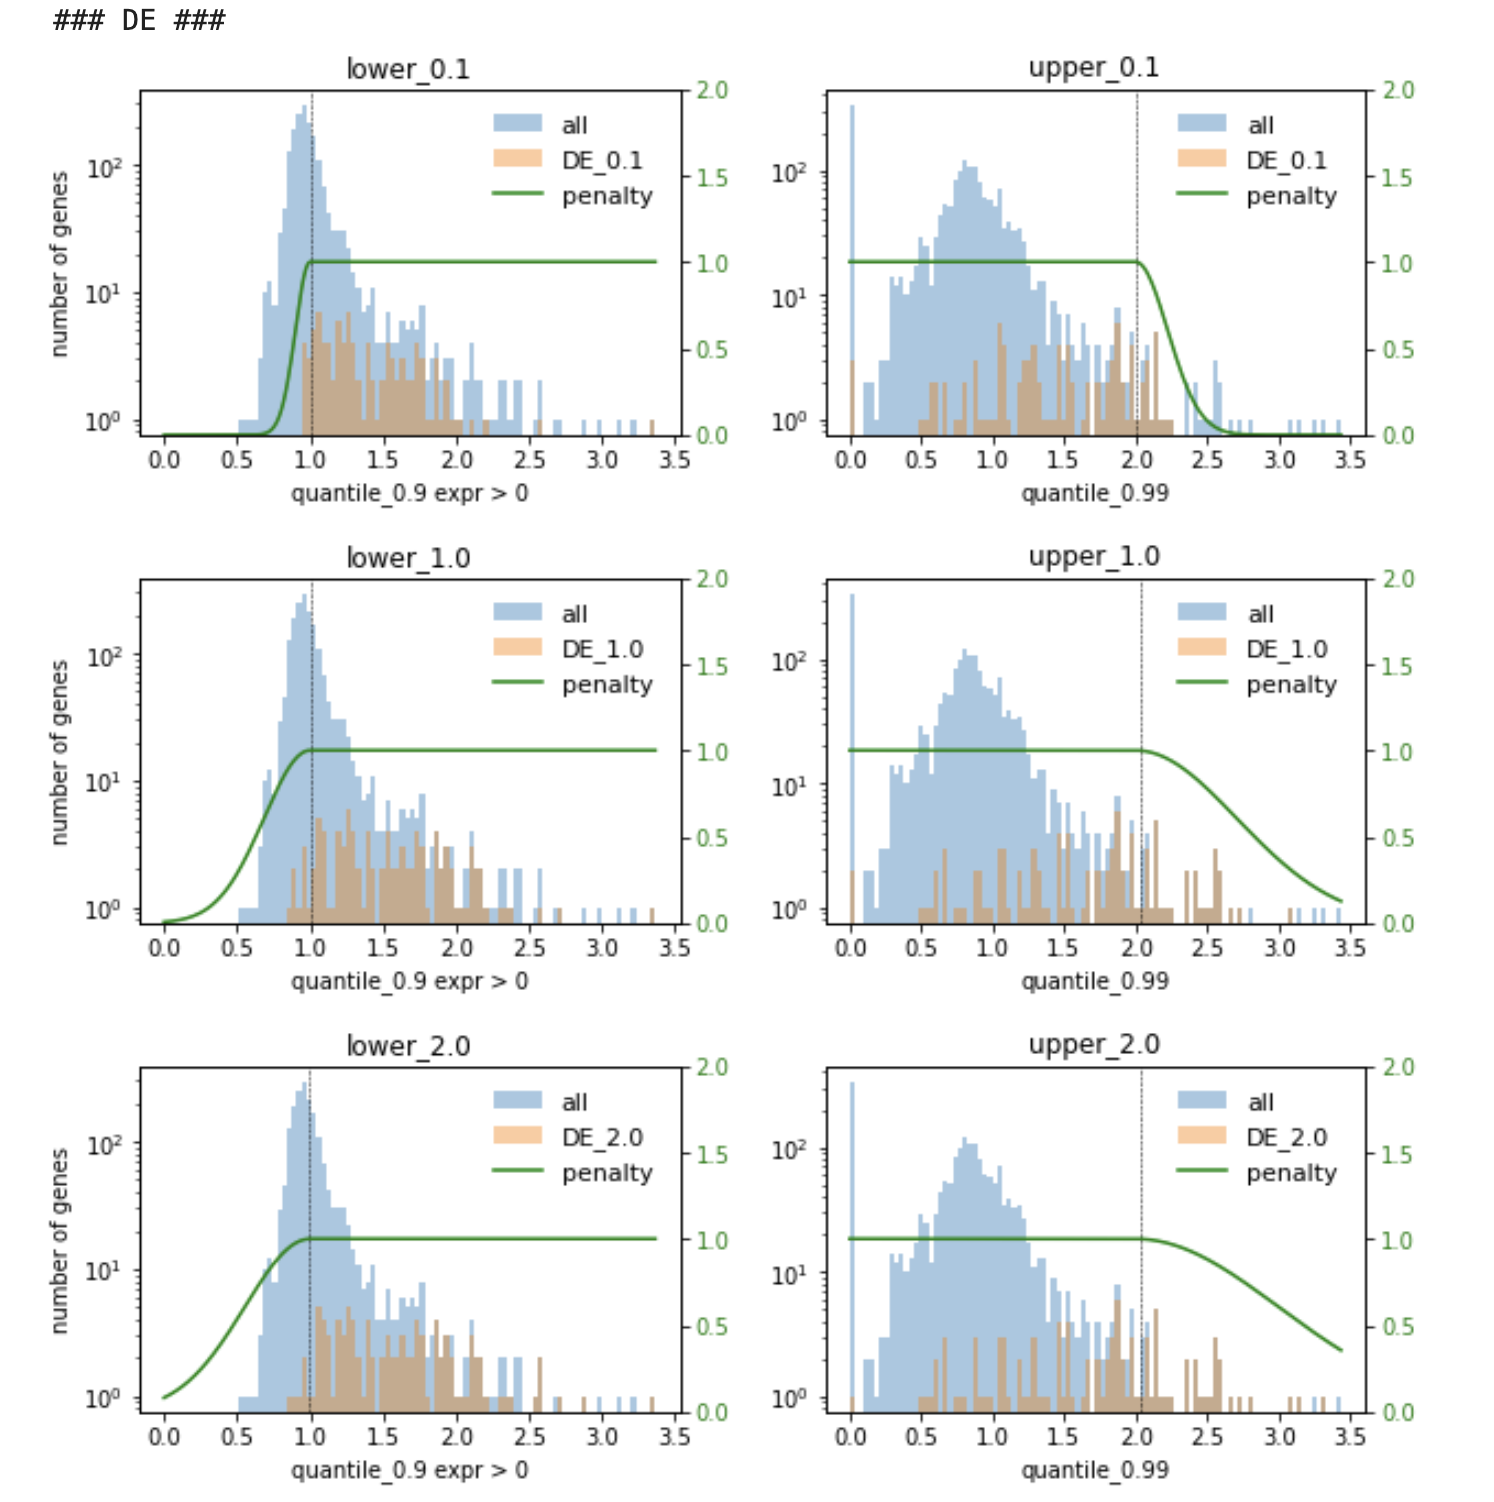

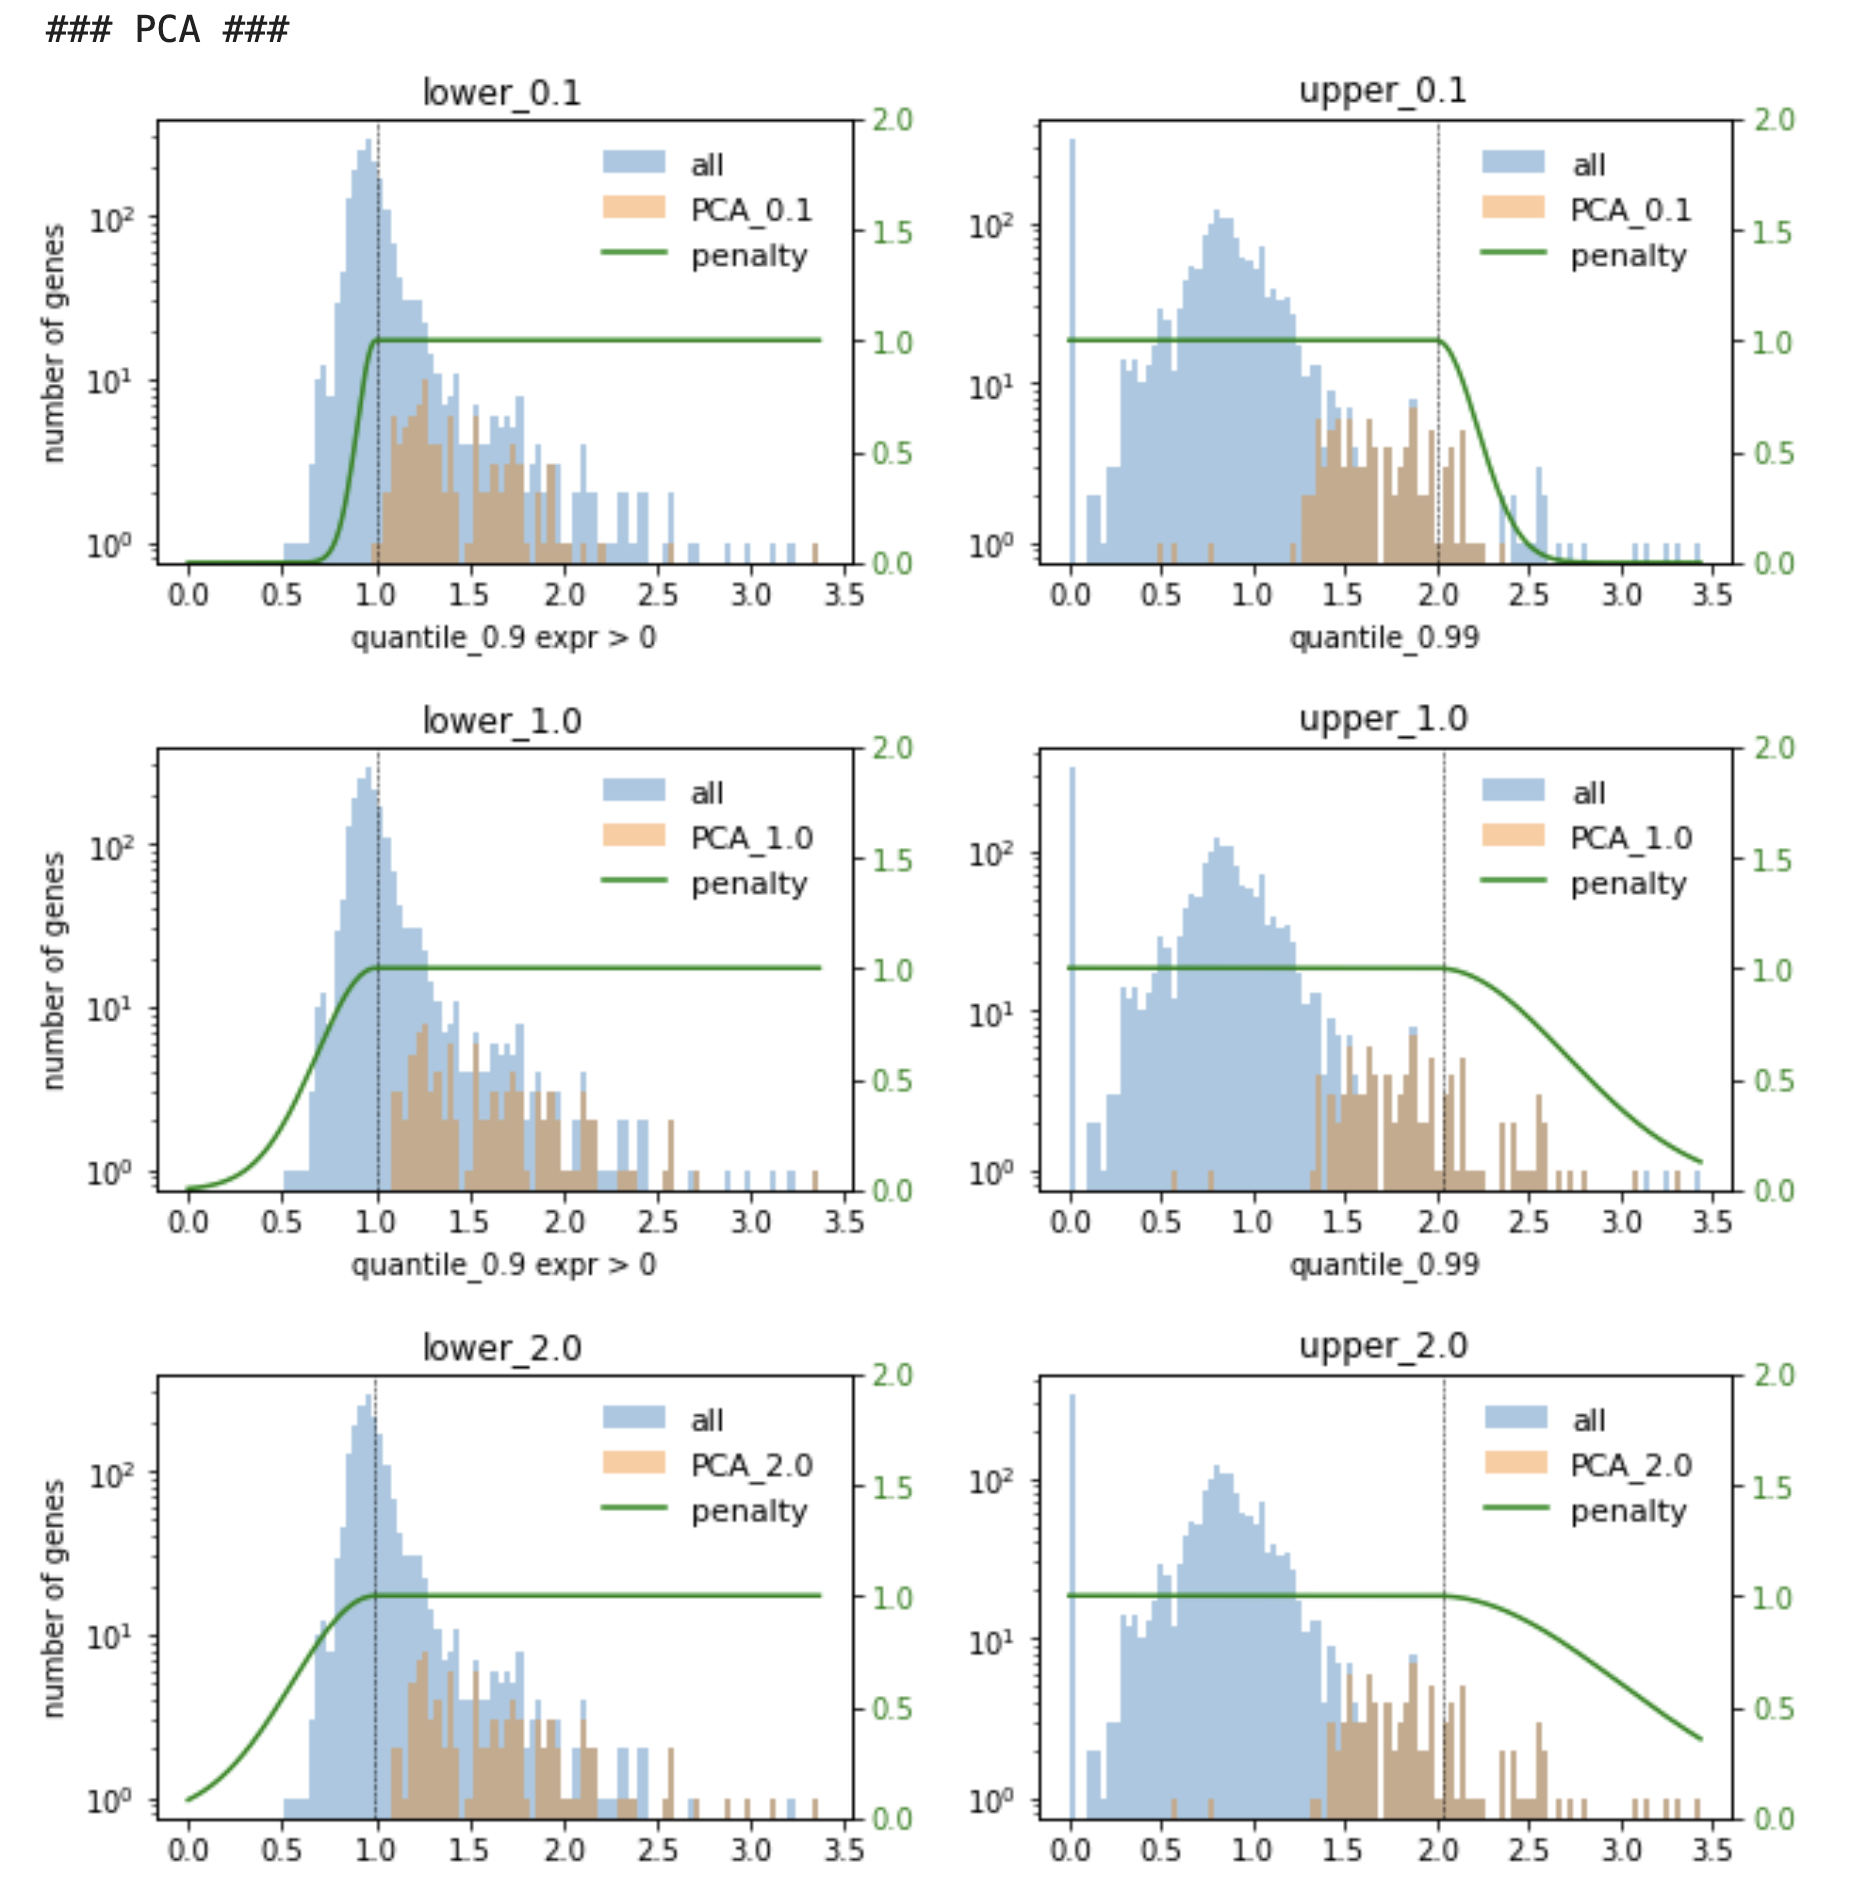

In this setting we choose the factor 0.1 to not select too many highly expressed genes. Lowly expressed genes are not selected anyway for the given selection thresholds. 

We apply the expression penalties on multiple selection steps (see below). The "m_penalties<...>" would not be necessary since we don't provide a marker list. For the case that a marker list is given the penalties should be applied as below: no lower penalty for `m_penalties_list_celltypes` since we don't expect cells from that cell type expressing those markers in the given data set.

In [25]:
# Run selection with the calibrated expession constraints

FACTOR = 0.1

# Get penalty functions for given factor
lower = sp.ut.plateau_penalty_kernel(var=0.1 * FACTOR, x_min=lower_th, x_max=None)
upper = sp.ut.plateau_penalty_kernel(var=0.5 * FACTOR, x_min=None, x_max=upper_th)

# Calculate each gene's penalty value
adata.var[f"expr_penalty_lower"] = lower(adata.var['quantile_0.9 expr > 0'])
adata.var[f"expr_penalty_upper"] = upper(adata.var['quantile_0.99'])

# create an instance of the ProbesetSelector class
selector = sp.se.ProbesetSelector(
    adata,
    n=None,
    celltype_key="celltype",
    verbosity=1,
    save_dir="spapros_selection_advanced_constraints",
    pca_penalties=["expr_penalty_lower", "expr_penalty_upper"],
    DE_penalties=["expr_penalty_lower", "expr_penalty_upper"],
    m_penalties_adata_celltypes=["expr_penalty_lower", "expr_penalty_upper"],
    m_penalties_list_celltypes=["expr_penalty_upper"],
)

Note: The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
The genes selected for those cell types potentially don't generalize well. Find the genes for each of those cell types in self.genes_of_primary_trees after running self.select_probeset().
Searching for previous results in spapros_selection_advanced_constraints


Again, we precomputed this for you: 
```python
selector.select_probeset()
```
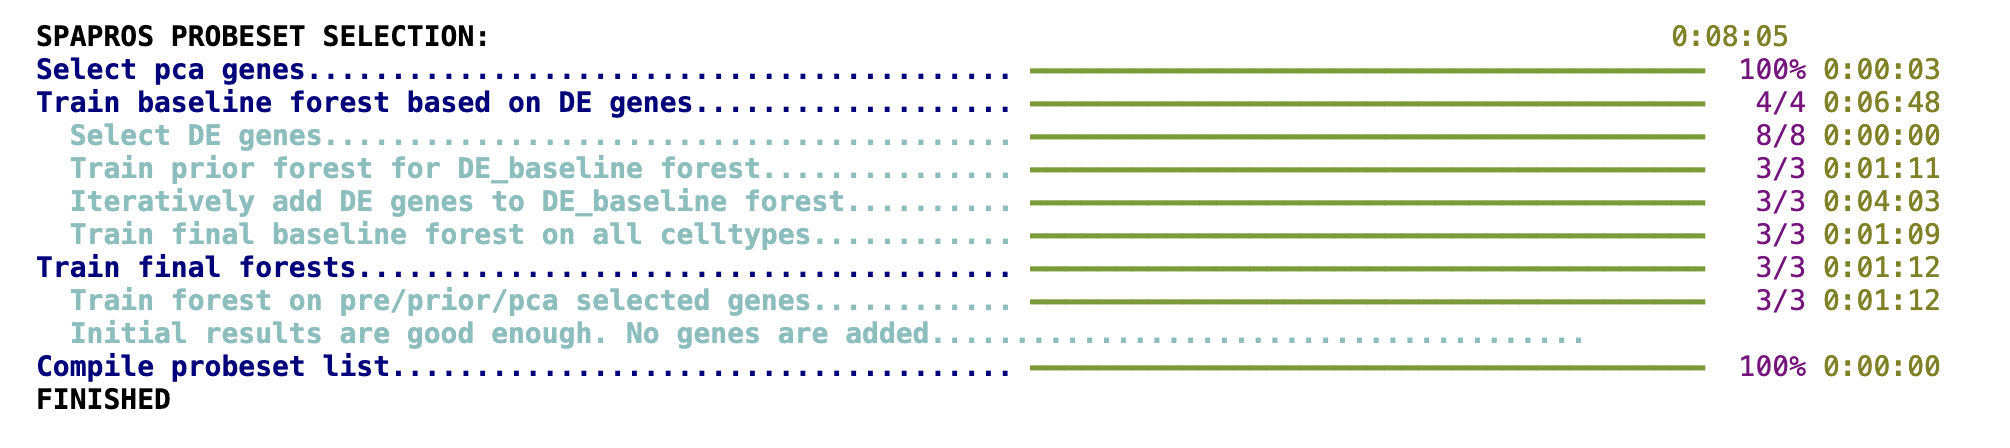

Now load the precomputed results: 

In [26]:
selector.select_probeset()

SPAPROS PROBESET SELECTION:                                                                      0:00:11
PCA genes already selected..................................................................  
Train baseline forest based on DE genes................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   4/4 0:00:00
  Differentially expressed genes already selected...........................................  
  Prior forest for DE_baseline forest already trained.......................................  
  DE genes already added....................................................................  
  DE_baseline forest already trained........................................................  
Train final forests....................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   3/3 0:00:00
  Forest on pre/prior/pca selected genes already trained....................................  
  Initial results are good enough. No genes are added.......................................  
Compile probeset list..................................... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  100% 0:00:02
FINISHED

We can then investigate if the genes selected with spapros are within the expression constraints with the `selector.plot_histogram` function.

In [61]:
selector.adata.var['quantile_0.9 expr > 0'] = selector.adata.var['quantile_0.9 expr > 0'].astype(float)

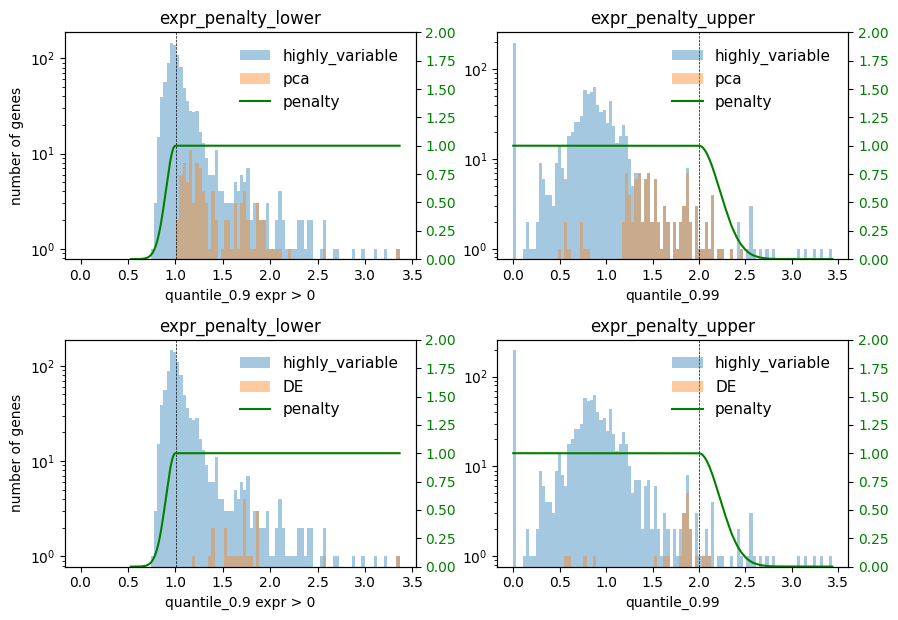

In [62]:
selector.plot_histogram(
    selections = ["pca", "DE"],
    x_axis_keys={"expr_penalty_lower": 'quantile_0.9 expr > 0', "expr_penalty_upper": 'quantile_0.99'},
    unapplied_penalty_keys={}
)


### vi. Your use case is not captured?

If you face a special use case and you're unsure if the described schemes would fit to this one, please raise an issue at [our github issue section](https://github.com/theislab/spapros/issues) and describe the use case.

## 3. What's next? 



- See our [basic evaluation tutorial](./spapros_tutorial_basic_evaluation.ipynb) and [advanced evaluation tutorial](./spapros_tutorial_advanced_evaluation.ipynb) for detailed instructions to evaluate the selected probesets.
- Check out our [end to end selection tutorial](./spapros_tutorial_end_to_end_selection.ipynb) for combining gene selection and probe design.